In [118]:
#%reset
"""
Definition of test problems
--------------------------------------------------------------------------
Created November 4 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
from trips.operators import *
import time
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import numpy as np
import astra
from trips.phantoms import *
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.testProblems import *
from trips.operators import *
from trips.solvers.gks_all import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.helpers import *
from trips.operators import *
from trips.solvers.CGLS import TP_cgls
from trips.solvers.golub_kahan_tikhonov import *
from trips.solvers.GMRES import GMRES

#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem where the forward operator can be formed explicitly as a matrix
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
2. Define a tomography problem where the forward operator is defined as a function and test solving the problem
3. Define a tomography problem by loading some saved data


#### 1. Define e tomography problem where the forward operator can be formed explicitly as a matrix

###### We define an operator, choose a phantom of any given size and plot the true phantom and the sinograpm as follows:

In [113]:
# Define an object of the class Tomogrpahy
Tomo = Tomography()
# Specify the dimensions of the phantom and the number of angels 
angels = 90
nx = 64
ny = 64
# Step 1: Define the operator as a matrix
Amat = Tomo.forward_Op_mat(nx, ny, angels)
# Step 2: Define the true solution. 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'tectonic'
(x_true, nx, ny) = Tomo.gen_true(nx, ny, testproblem)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, True, nx, ny, angels)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.1 means 10% additive noise
(b, e) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)

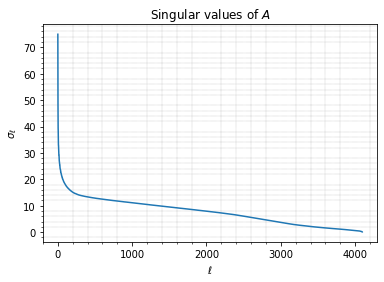

In [116]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fa5fb8311f0>)

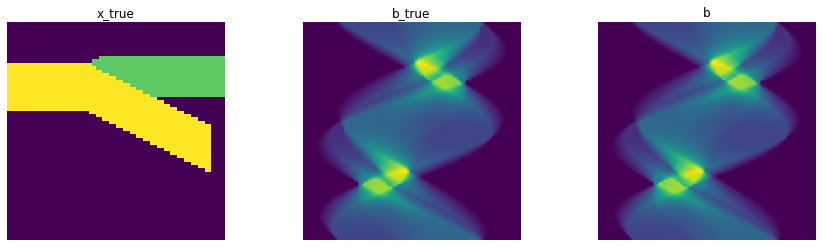

In [103]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

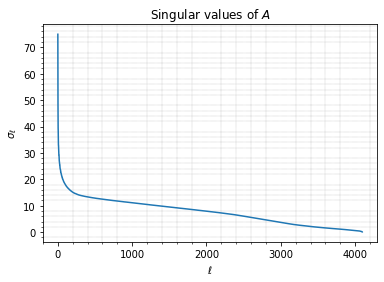

In [104]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

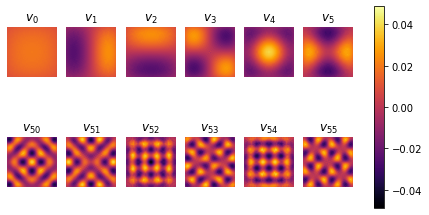

In [105]:
plot_singular_vectors_svd(Operator = A.todense(), size = nx, parameter = 'A')

##### 1.1. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

(-0.5, 63.5, 63.5, -0.5)

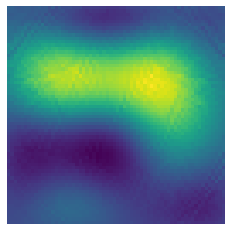

In [106]:
truncated_value = 15
b_vec = b.reshape((-1,1))
x_tsvd = TruncatedSVD_sol(A.todense(), truncated_value, b_vec)
plt.imshow(x_tsvd.reshape((nx, ny)))
plt.axis('off')

#### 1.2 Compute an approximate solution by using Generalized Krylov Subspace method (GKS)

In [120]:
# First we compute a naive solution
x_naive = A.T@b.reshape((-1,1))

In [108]:
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 5, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = np.linalg.norm(e))

running GKS...: 100%|██████████| 5/5 [02:14<00:00, 26.82s/it]


(<AxesSubplot:title={'center':'x_gks'}>,
 Text(0.5, 1.0, 'x_gks'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fa7838a6c10>)

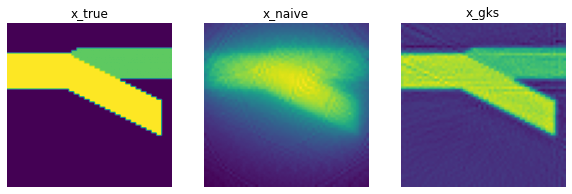

In [121]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(10,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('x_naive'), plt.axis('off'), plt.imshow(x_naive.reshape((nx,ny)))
plt.subplot(1,3,3), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx, ny)))

2. Define a tomography problem where the forward operator is defined as a function and test solving the problem

In [49]:
# Define an object of the class Tomogrpahy
Tomo1 = Tomography()
# Specify the dimensions of the phantom and the number of angels 
views = 90
nx = 256
ny = 256
# Step 1: Define the true solution. 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'ppower'
(x_true, nx, ny) = Tomo1.gen_true(nx, ny, testproblem)
# Step 2: Define the operator as a matrix
A = Tomo1.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo1.gen_data(x_true, True, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.1 means 10% additive noise
(b, e) = Tomo1.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)
delta = np.linalg.norm(e)
b_vec = b.reshape((-1,1))

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fa79eddf610>)

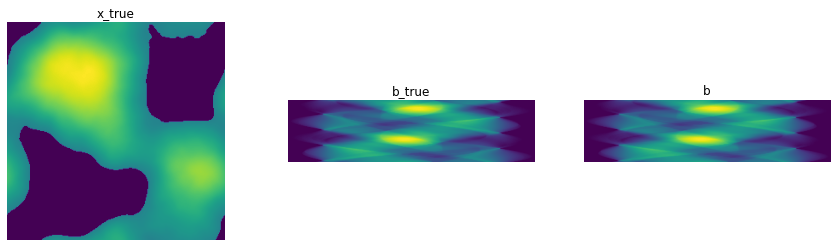

In [57]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

<p> Step 1: Compute a solution Golub-Kahan
<p> Step 2: Compute a solution Golub-Kahan-Tikhonov
<p> Step 2: Compute a solution by GKS


generating basis...: 100%|██████████| 10/10 [00:00<00:00, 26.07it/s]


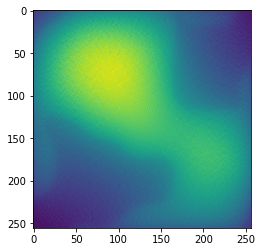

In [58]:
# Compute a solution Golub-Kahan
projection_dim = 10
(U, B, V) = golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = B[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)
plt.imshow(x_GKahan.reshape((nx,ny)))

In [59]:
# Compute a solution Golub-Kahan-Tikhonov
(xgolub_kahan_tikhonov, reg_param) = golub_kahan_tikhonov(A, b.reshape((-1,1)), n_iter = 10, regparam = 'gcv', delta = delta)

generating basis...: 100%|██████████| 3/3 [00:00<00:00, 24.70it/s]


In [63]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 10, regparam = 'gcv', x_true = x_true.reshape(-1,1))

running GKS...: 100%|██████████| 10/10 [00:55<00:00,  5.55s/it]


(<AxesSubplot:title={'center':'x_gks'}>,
 Text(0.5, 1.0, 'x_gks'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fa78ca74760>)

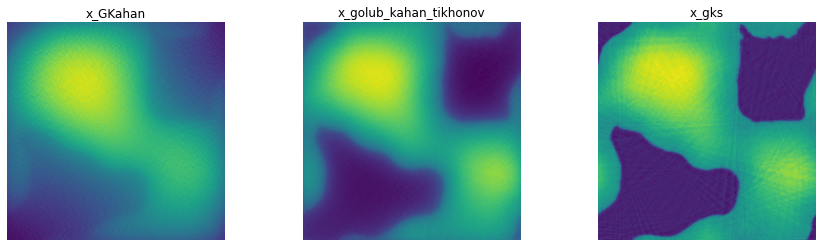

In [64]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_GKahan'), plt.axis('off'), plt.imshow(x_GKahan.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('x_golub_kahan_tikhonov'), plt.axis('off'), plt.imshow(xgolub_kahan_tikhonov.reshape((nx, ny)))
plt.subplot(1,3,3), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx,ny)))

### 3. Define a tomography problem by loading some saved data

In [68]:
# Define an object of the class Tomogrpahy
Tomo2 = Tomography()
# Specify the dimensions of the phantom and the number of angels 
# Step 1: Define the true solution. 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'head'
(x_true, nx, ny) = Tomo1.gen_true(nx, ny, testproblem)
# Step 2: Define the operator as a matrix
A = Tomo1.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, x_true, b) = Tomo1.gen_saved_data('head')
b_vec = b.reshape((-1,1))

In [69]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 10, regparam = 1, x_true = x_true.reshape(-1,1))

running GKS...: 100%|██████████| 10/10 [03:45<00:00, 22.59s/it]


(Text(0.5, 1.0, 'x_gks'), (-0.5, 511.5, 511.5, -0.5))

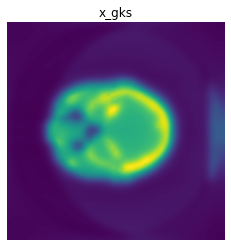

In [70]:
# Display the solution 
plt.imshow(x_gks.reshape((nx,ny)))
plt.title('x_gks'), plt.axis('off')